# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
%matplotlib inline

In [3]:
from relaxed.plot_defaults import *

In [4]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import scipy
import warnings

import matplotlib as mpl
from sklearn.model_selection import train_test_split


In [5]:
from relaxed.analysis import setup, get_quantiles, gaussian_conditional, get_am, get_a2_from_am, get_lam

# Data

In [6]:
# catalog
hcat, indices, scales = setup('m11', path='../../output')
cvir = hcat.cat['cvir']

# obtain a_m
am, mass_bins = get_am('m11', min_mass=0.1, path='../../output')
a2 = get_a2_from_am(am, mass_bins)

# throw away first & last, useless bin (a = 1.00 always for that)
am = am[:, 1:-1]
mass_bins = mass_bins[1:-1]
print(am.shape, mass_bins.shape, a2.shape, cvir.shape)

(9999, 98) (98,) (9999,) (9999,)


In [7]:
 # remove nan's from lam along the way, like ~600 haloes.
keep, lam, cvir, a2 = get_lam(am, cvir, a2)
am = am[keep]
print(sum(keep), lam.shape, cvir.shape, a2.shape, am.shape)

9449 (9449, 98) (9449,) (9449,) (9449, 98)


In [9]:
# train/test split.
lam_train, lam_test, cvir_train, cvir_test, a2_train, a2_test, am_train, am_test = train_test_split(lam, cvir, a2, am, test_size=0.33)
print(cvir_train.shape)
print(cvir_test.shape)

(6330,)
(3119,)


# Train

In [14]:
# multivariate prediction
mu1, mu2, Sigma, rho, mu_cond, sigma_cond = gaussian_conditional(np.log(cvir_train), lam_train)
def multi_gauss(lam_test):
    return np.exp(mu_cond(lam_test))

# lognormal samples 
mu, sigma = np.mean(np.log(cvir_train)), np.std(np.log(cvir_train))
def lognormal(lam_test): 
    n_test = len(lam_test)
    log_cvir_pred = np.random.normal(mu, sigma, n_test)
    return np.exp(log_cvir_pred)


# rank approach
from scipy.interpolate import interp1d
cvir_sort, a2_sort = np.sort(-cvir_train), np.sort(a2_train)
cvir_sort = -cvir_sort
marks = np.arange(len(cvir_sort)) / len(cvir_sort)
marks += (marks[1] - marks[0]) / 2
a2_to_mark = interp1d(a2_sort, marks, fill_value=(0, 1), bounds_error=False)
mark_to_cvir = interp1d(marks, cvir_sort, fill_value=(cvir_sort[0], cvir_sort[-1]), bounds_error=False)

def cam(lam_test):
    _a2_test = get_a2_from_am(np.exp(lam_test), mass_bins)
    assert np.all(_a2_test == a2_test)
    return mark_to_cvir(a2_to_mark(_a2_test))

# multi-normal but just using a_{1/2}
indx = np.where((0.498 < mass_bins) & (mass_bins < 0.51))[0].item()
_, _, _, _, mu_cond_a2, _  = gaussian_conditional(np.log(cvir_train), lam_train[:, indx].reshape(-1, 1))
def a2_gauss(lam_test):
    return np.exp(mu_cond_a2(lam_test[:, indx].reshape(-1, 1)))

# linear regression 
# requires shape (n_samples, n_features)
from sklearn.linear_model import LinearRegression 
from scipy import stats
reg1 = LinearRegression().fit(lam_train, np.log(cvir_train))

def linreg(lam_test):
    return np.exp(reg1.predict(lam_test))

# linear regression (no logs)
reg2 = LinearRegression().fit(am_train, cvir_train) 
def linreg_no_logs(lam_test):
    return reg2.predict(np.exp(lam_test))

# gaussian remapping
from sklearn.preprocessing import QuantileTransformer
qt_cvir = QuantileTransformer(n_quantiles=len(cvir), output_distribution='normal').fit(cvir.reshape(-1,1))
qt_am = QuantileTransformer(n_quantiles=len(am), output_distribution='normal').fit(am)

cvir_trans_train = qt_cvir.transform(cvir_train.reshape(-1, 1))
am_trans_train = qt_am.transform(am_train)
_, _, _, _, mu_cond_trans, _ = gaussian_conditional(cvir_trans_train.reshape(-1), am_trans_train)
def multi_gauss_trans(lam_test):
    am_trans_test = qt_am.transform(np.exp(lam_test))
    cvir_trans_pred = mu_cond_trans(am_trans_test)
    cvir_pred = qt_cvir.inverse_transform(cvir_trans_pred.reshape(-1, 1))
    return cvir_pred.reshape(-1)

# Plots

## Combined histogram of residuals

In [15]:
# funcs are trained functions that take in lam_test and return cvir_pred, colors are color for each function.
def combined_histogram(lam_test, X_test, *funcs, colors=('r', 'b', 'g'), labels=('1', '2', '3')):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    bins = None
    correlations = []
    for i, f in enumerate(funcs):
        X_pred = f(lam_test)
        x = (X_pred - X_test) / X_test
        if bins is None: 
            bins = get_bins(x, range=(-1, 3)) # share bins between all histograms.
        draw_histogram(ax, x, vline=None, label=labels[i], color=colors[i], 
                       bins=bins, density=False)
        
        print(f'{labels[i]} corr: {scipy.stats.spearmanr(X_pred, X_test)[0]}')
        
    ax.axvline(0, color='k', ls='--')
    ax.legend()
    ax.set_ylabel(r"\rm Counts", size=28)
    ax.set_xlabel(r"$(c^{\rm pred}_{\rm vir} - c^{\rm test}_{\rm vir}) / c^{\rm test}_{\rm vir}$", size=28)

MG-FC corr: 0.7511734566683222
LN-RS corr: -0.010554930883984476
CAM corr: 0.6851685303380062
MV-LR corr: 0.7511734566683222
MG-TFC corr: 0.7526930968082088
MG-A2 corr: 0.7143501630596081
MV-LR-NL corr: 0.6851685303380062


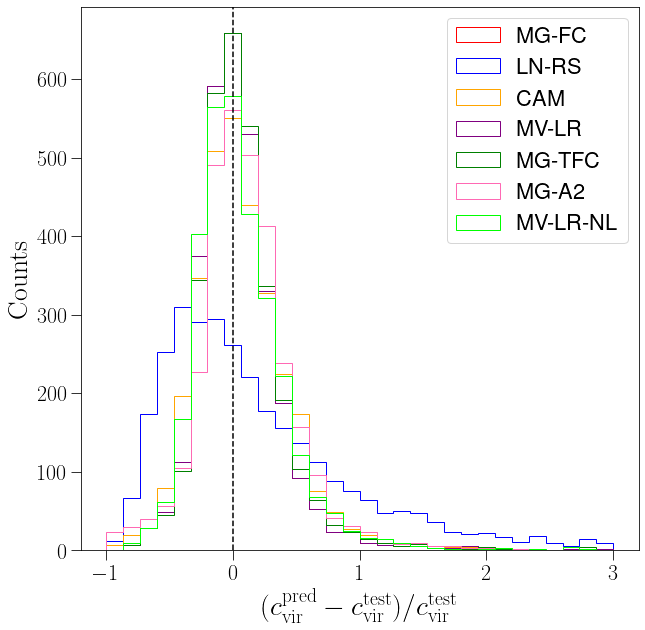

In [16]:
labels = ['MG-FC', 'LN-RS', 'CAM', 'MV-LR', 'MG-TFC', 'MG-A2', 'MV-LR-NL']
colors = ['r', 'b', 'orange', 'purple', 'g', 'hotpink', 'lime']
combined_histogram(lam_test, cvir_test, multi_gauss, lognormal, cam, linreg, multi_gauss_trans, linreg_no_logs, a2_gauss, labels=labels, colors=colors)

## Scatter plots of residuals

In [17]:
def scatter_plots(lam_test, X_test, *funcs, colors=('r', 'b', 'g'), labels=('1', '2', '3'), alpha=0.5): 
    fig, axes = plt.subplots(1, 3, figsize=(21, 7))
    ax1, ax2, ax3 = axes.flatten()
    for i, f in enumerate(funcs):
        X_pred = f(lam_test)
        a_2_test = get_a2_from_am(np.exp(lam_test), mass_bins)
        x = X_pred / X_test
        
        ax1.scatter(X_test, x, alpha=alpha, color=colors[i], label=labels[i])
        ax1.set_xlabel(r"$c^{\rm true}_{\rm vir}$")
        ax1.set_ylabel(r"$c^{\rm pred}_{\rm vir}/ c^{\rm true}_{\rm vir}$")
        
        
        ax2.scatter(X_pred, x, alpha=alpha, color=colors[i], label=labels[i])
        ax2.set_xlabel(r"$c^{\rm pred}_{\rm vir}$")
        ax2.set_ylabel(r"$c^{\rm pred}_{\rm vir}/ c^{\rm true}_{\rm vir}$")    
    
        ax3.scatter(a_2_test, x, alpha=alpha, color=colors[i], label=labels[i])
        ax3.set_xlabel(r"$a_{1/2}^{\rm true}$")
        ax3.set_ylabel(r"$c^{\rm pred}_{\rm vir}/ c^{\rm true}_{\rm vir}$")  
        
        # add median line
        print(f'median {labels[i]}: ', np.median(x))
        ax1.axhline(1, ls='--', color='k')
        ax2.axhline(1, ls='--', color='k')
        ax3.axhline(1, ls='--', color='k')

        # set scales.
        ax1.set_xscale('log')
        ax2.set_xscale('log')
        
        ax1.set_yscale('log')
        ax2.set_yscale('log')
        ax3.set_yscale('log')
        
        ax1.legend()
    plt.tight_layout()

median MG-FC:  1.01261760799024
median LN-RS:  1.0157695058318357
median CAM:  1.0207873059382728
median MG-TFC:  1.0212459478394744


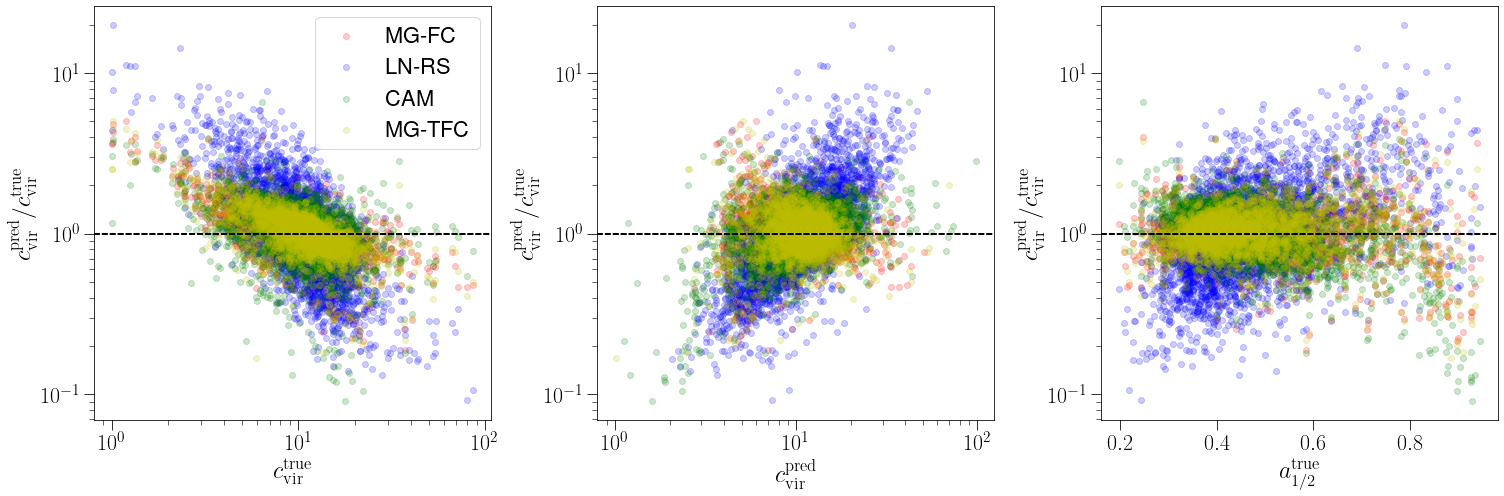

In [18]:
labels = ['MG-FC', 'LN-RS', 'CAM', 'MG-TFC']
colors = ['r', 'b', 'g', 'y']
scatter_plots(lam_test, cvir_test, multi_gauss, lognormal, cam, multi_gauss_trans, labels=labels, colors=colors, alpha=0.2)

## Median bin statistic

In [19]:
def make_scatter_binning(ax, x, y, n_xbins=15, bin_bds=None, show_bands=True, color='r', label=''):

    if bin_bds is not None:
        # ignore n_xbins
        size = len(bin_bds) - 1
        x_bds = np.array([(bin_bds[i], bin_bds[i + 1]) for i in range(size)])
    else:
        # divide uniformly.
        xs = np.linspace(np.min(x), np.max(x), n_xbins)
        x_bds = np.array([(xs[i], xs[i + 1]) for i in range(len(xs) - 1)])

    masks = [((x_bd[0] < x) & (x < x_bd[1])) for x_bd in x_bds]

    xbins = [x[mask] for mask in masks if len(x[mask]) > 0 and len(y[mask])>0]  # remove empty ones.
    ybins = [y[mask] for mask in masks if len(x[mask]) > 0 and len(y[mask])>0]

    xmeds = np.array([np.median(xbin) for xbin in xbins])
    ymeds = np.array([np.median(ybin) for ybin in ybins])

    ax.errorbar(
        xmeds,
        ymeds,
        fmt="o-",
        color=color,
        label=label,
        capsize=10,
    )

    y1 = np.array([np.quantile(ybin, 0.25) for ybin in ybins])
    y2 = np.array([np.quantile(ybin, 0.75) for ybin in ybins])

    if show_bands:
        ax.fill_between(xmeds, y1, y2, alpha=0.2, linewidth=0.001, color=color)

In [20]:
def median_bin_statistic(lam_test, X_test, *funcs, colors=('r', 'b', 'g'), labels=('1', '2', '3')):
    fig, axes = plt.subplots(1, 3, figsize=(21, 7))
    ax1, ax2, ax3 = axes.flatten()
    for i, f in enumerate(funcs):
        X_pred = f(lam_test)
        a_2_test = get_a2_from_am(np.exp(lam_test), mass_bins)
        x = X_pred / X_test
        
        make_scatter_binning(ax1, X_test, x, color=colors[i], label=labels[i])
        ax1.set_xlabel(r"$c^{\rm true}_{\rm vir}$")
        ax1.set_ylabel(r"$c^{\rm pred}_{\rm vir}/ c^{\rm true}_{\rm vir}$")
        

        make_scatter_binning(ax2, X_pred, x, color=colors[i], label=labels[i])
        ax2.set_xlabel(r"$c^{\rm pred}_{\rm vir}$")
        ax2.set_ylabel(r"$c^{\rm pred}_{\rm vir}/ c^{\rm true}_{\rm vir}$")    
    
        make_scatter_binning(ax3, a_2_test, x, color=colors[i], label=labels[i])
        ax3.set_xlabel(r"$a_{1/2}^{\rm true}$")
        ax3.set_ylabel(r"$c^{\rm pred}_{\rm vir}/ c^{\rm true}_{\rm vir}$")  
        
        ax1.axhline(1, ls='--', color='k')
        ax2.axhline(1, ls='--', color='k')
        ax3.axhline(1, ls='--', color='k')

        # set scales.
        ax1.set_xscale('log')
        ax2.set_xscale('log')
        
        ax1.set_yscale('log')
        ax2.set_yscale('log')
        ax3.set_yscale('log')
        
        ax1.legend()
    plt.tight_layout()

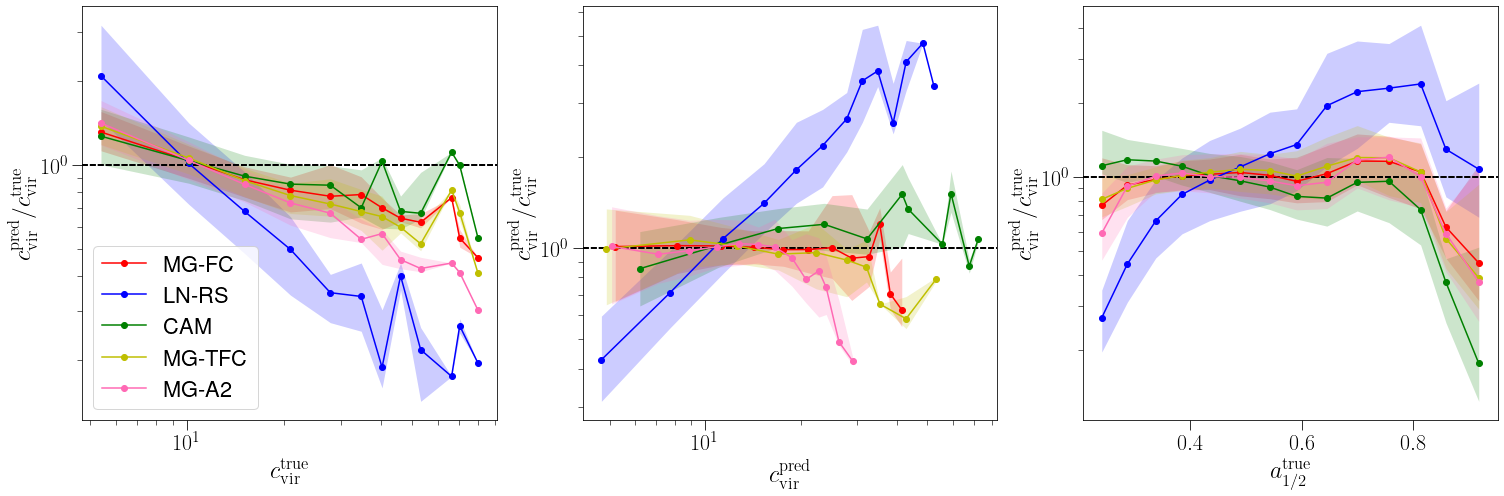

In [21]:
labels = ['MG-FC', 'LN-RS', 'CAM', 'MG-TFC', 'MG-A2']
colors = ['r', 'b', 'g', 'y', 'hotpink']
median_bin_statistic(lam_test, cvir_test, multi_gauss, lognormal, cam, multi_gauss_trans, a2_gauss, labels=labels, colors=colors)